
<a id='multiplicative-functionals'></a>
<div id="qe-notebook-header" style="text-align:right;">
        <a href="https://quantecon.org/" title="quantecon.org">
                <img style="width:250px;display:inline;" src="https://assets.quantecon.org/img/qe-menubar-logo.svg" alt="QuantEcon">
        </a>
</div>

# Funcionais Multiplicativas


<a id='index-0'></a>

## Conteúdo

- [Funcionais Multiplicativas](#Funcionais-Multiplicativas)  
- [Resumo](#Resumo)  
- [Um Processo de Log-Verossimilhança](#Um-Processo-de-Log-Verossimilhança)  
- [Benefícios das Flutuações Agregadas Reduzidas](#Benefícios-das-Flutuações-Agregadas-Reduzidas)  

> *Devidamente traduzido, revisado e adaptado do [QuantEcon](https://quantecon.org/) pelos bolsistas CNPq, Pedro Luiz H. Furtado e Jonas Aragão M. Corpes, sob supervisão do Prof. Christiano Penna, do CAEN/UFC.*

Em co-autoria com Chase Coleman e Balint Szoke.

## Resumo

Esta aula é uma sequência da [aula sobre funcionais aditivos](https://julia.quantecon.org/additive_functionals.html).

Essa aula:

1. Definiu uma classe especial de **funcionais aditivos** conduzidos por um vetor VAR de primeira ordem;
2. Tomando o exponencial desse funcional aditivo, criou um **funcional multiplicativo associado**.


Esta aula usa esta aula especial para criar e analisar dois exemplos:

- Um **processo de verossimilhança**, um objeto na base das abordagens frequentista e bayesiana da inferência estatística.
- Uma versão de Robert E. Lucas [Luc03](https://julia.quantecon.org/../zreferences.html#lucas2003) e Thomas Tallarini [Tal00](https://julia.quantecon.org/../zreferences.html#tall2000) aborda a medição dos benefícios de moderar flutuações agregadas.  

## Um Processo de Log-Verossimilhança

Considere um vetor de funcionais aditivos $ \{y_t \} _ {t = 0} ^ \infty $ descrito por:

$$
\begin{aligned}
    x_{t+1} & = A x_t + B z_{t+1}
    \\
    y_{t+1} - y_t & = D x_{t} + F z_{t+1},
\end{aligned}
$$

onde $ A $ é uma matriz estável, $ \{z_{t + 1} \} _{t = 0}^\infty $ é
um sequência i.i.d. de vetores aleatórios $ {\cal N} (0, I) $, $ F $ é
não singular e $ x_0 $ e $ y_0 $ são vetores de 
números conhecidos.

Evidentemente,

$$
x_{t+1} = \left(A - B F^{-1}D \right)x_t
    + B F^{-1} \left(y_{t+1} - y_t \right),
$$

para que $ x_{t + 1} $ possa ser construído a partir de observações em
$ \{y_{s}\}_{s=0}^{t+1} $ and $ x_0 $.

A distribuição de $ y_{t + 1} - y_t $ condicional em $ x_t $ é normal com média $ Dx_t $ e matriz de covariância não singular $ FF'$.

Seja $ \theta $ denotando o vetor de parâmetros livres do modelo.

Esses parâmetros definem os elementos de $ A, B, D, F $.

A **função de probabilidade de log** de $ \{y_s \}_{s = 1}^t $ é

$$
\begin{aligned}
    \log L_{t}(\theta)  =
    & - {\frac 1 2} \sum_{j=1}^{t} (y_{j} - y_{j-1} -
         D x_{j-1})'(FF')^{-1}(y_{j} - y_{j-1} - D x_{j-1})
    \\
    & - {\frac t 2} \log \det (FF') - {\frac {k t} 2} \log( 2 \pi)
\end{aligned}
$$

Vamos considerar o caso de um processo escalar em que $ A, B, D, F $ são escalares e $ z_{t + 1} $ é um processo estocástico escalar.

Deixamos $ \theta_o $ denotar os valores "verdadeiros" de $ \theta $, ou seja, os valores que geram os dados.

Para os fins deste exercício, defina $ \theta_o = (A, B, D, F) = (0,8, 1, 0,5, 0,2) $.

Defina $ x_0 = y_0 = 0 $.

### Simulando caminhos simples

Vamos escrever um programa para simular exemplos de caminhos de $ \{x_t, y_{t} \}_{t = 0}^{\infty} $.

Faremos isso formulando o funcional aditivo como um modelo linear de espaço de estado e colocando a estrutura [LSS](https://github.com/QuantEcon/QuantEcon.jl/blob/master/src/lss.jl) para funcionar.

### Configuração

In [1]:
using InstantiateFromURL
github_project("QuantEcon/quantecon-notebooks-julia", version = "0.5.0")
# github_project("QuantEcon/quantecon-notebooks-julia", version = "0.5.0", instantiate = true) # uncomment to force package installation

In [2]:
using LinearAlgebra, Statistics
using Distributions, Parameters, Plots, QuantEcon
import Distributions: loglikelihood
gr(fmt = :png);

In [3]:
AMF_LSS_VAR = @with_kw (A, B, D, F = 0.0, ν = 0.0, lss = construct_ss(A, B, D, F, ν))

function construct_ss(A, B, D, F, ν)
    H, g = additive_decomp(A, B, D, F)

    # Construir uma matriz A para LSS
    # Ordem das variáveis de estado é: [1, t, xt, yt, mt]
    A1 = [1 0 0 0 0]       # Transição para 1
    A2 = [1 1 0 0 0]       # Transição para t
    A3 = [0 0 A 0 0]       # Transição para x_{t+1}
    A4 = [ν 0 D 1 0]       # Transição para y_{t+1}
    A5 = [0 0 0 0 1]       # Transição para m_{t+1}
    Abar = vcat(A1, A2, A3, A4, A5)

    # Construir uma matriz B para LSS
    Bbar = [0, 0, B, F, H]

    # Build G matrix for LSS
    # Ordem de observação: [xt, yt, mt, st, tt]
    G1 = [0 0 1 0 0]               # Seletor para x_{t}
    G2 = [0 0 0 1 0]               # Seletor para y_{t}
    G3 = [0 0 0 0 1]               # Seletor para martingale
    G4 = [0 0 -g 0 0]              # Seletor para stationary
    G5 = [0 ν 0 0 0]               # Seletor para trend
    Gbar = vcat(G1, G2, G3, G4, G5)

    # Construir a estrutura LSS
    x0 = [0, 0, 0, 0, 0]
    S0 = zeros(5, 5)
    return LSS(Abar, Bbar, Gbar, mu_0 = x0, Sigma_0 = S0)
end

function additive_decomp(A, B, D, F)
    A_res = 1 / (1 - A)
    g = D * A_res
    H = F + D * A_res * B

    return H, g
end

function multiplicative_decomp(A, B, D, F, ν)
    H, g = additive_decomp(A, B, D, F)
    ν_tilde = ν + 0.5 * H^2

    return ν_tilde, H, g
end

function loglikelihood_path(amf, x, y)
    @unpack A, B, D, F = amf
    T = length(y)
    FF = F^2
    FFinv = inv(FF)
    temp = y[2:end] - y[1:end-1] - D*x[1:end-1]
    obs =  temp .* FFinv .* temp
    obssum = cumsum(obs)
    scalar = (log(FF) + log(2pi)) * (1:T-1)
    return -0.5 * (obssum + scalar)
end

function loglikelihood(amf, x, y)
    llh = loglikelihood_path(amf, x, y)
    return llh[end]
end

loglikelihood (generic function with 4 methods)

O trabalho pesado é feito dentro da estrutura AMF_LSS_VAR.

O código a seguir inclui algumas funções simples que facilitam a geração de caminhos de exemplo a partir de uma instância de AMF_LSS_VAR.

In [4]:
function simulate_xy(amf, T)
    foo, bar = simulate(amf.lss, T)
    x = bar[1, :]
    y = bar[2, :]
    return x, y
end

function simulate_paths(amf, T = 150, I = 5000)
    # Espaço alocado
    storeX = zeros(I, T)
    storeY = zeros(I, T)

    for i in 1:I
        # Fazer simulação específica
        x, y = simulate_xy(amf, T)

        # Preencher nossas matrizes de armazenamento
        storeX[i, :] = x
        storeY[i, :] = y
    end

    return storeX, storeY
end

function population_means(amf, T = 150)
    # Espaço alocado
    xmean = zeros(T)
    ymean = zeros(T)

    # Retirar nosso gerador de momentos
    moment_generator = moment_sequence(amf.lss)
    for (tt, x) = enumerate(moment_generator)
        ymeans = x[2]
        xmean[tt] = ymeans[1]
        ymean[tt] = ymeans[2]
        if tt == T
            break
        end
    end
    return xmean, ymean
end

population_means (generic function with 2 methods)

Agora que temos essas funções em nosso kit de anotações, vamos aplicá-las para executar algumas
simulações.

Em particular, vamos usar nosso programa para gerar  $ I = 5000 $ caminhos de amostra de comprimento $ T = 150 $, rotulados como $ \{x_{t}^i, y_{t}^i \}_{t = 0}^\infty $ por $ i = 1, ..., I $.

Em seguida, calculamos as médias de $ \frac {1} {I} \sum_i x_t^i $ e $ \frac {1} {I} \sum_i y_t ^ i $ nos caminhos de amostra e as comparamos com as médias da população de $ x_t $ e $ y_t $.

Aqui segue:

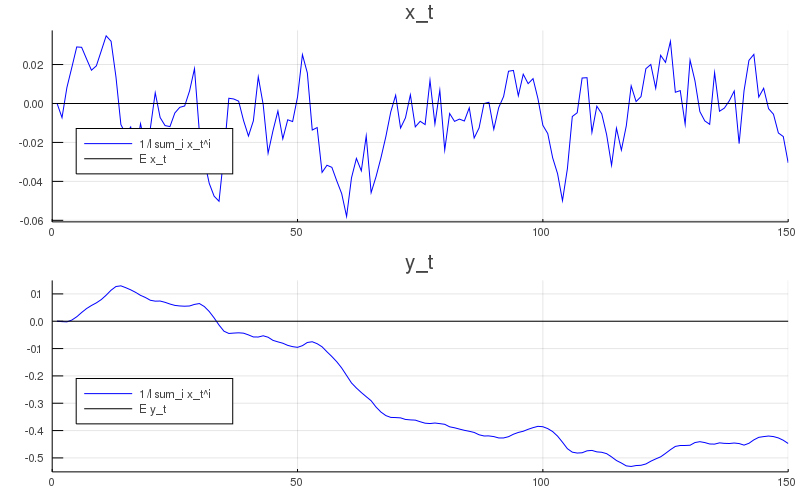

In [5]:
F = 0.2
amf = AMF_LSS_VAR(A = 0.8, B = 1.0, D = 0.5, F = F)

T = 150
I = 5000

# Simular e computar as médias simples
Xit, Yit = simulate_paths(amf, T, I)
Xmean_t = mean(Xit, dims = 1)
Ymean_t = mean(Yit, dims = 1)

# Computar as médias populacionais
Xmean_pop, Ymean_pop = population_means(amf, T)

# Plotar médias simples x médias populacionais
plt_1 = plot(Xmean_t', color = :blue, label = "1/I sum_i x_t^i")
plot!(plt_1, Xmean_pop, color = :black, label = "E x_t")
plot!(plt_1, title = "x_t", xlim = (0, T), legend = :bottomleft)

plt_2 = plot(Ymean_t', color = :blue, label = "1/I sum_i x_t^i")
plot!(plt_2, Ymean_pop, color = :black, label = "E y_t")
plot!(plt_2, title = "y_t", xlim = (0, T), legend = :bottomleft)

plot(plt_1, plt_2, layout = (2, 1), size = (800,500))

### Simulando log-verossimilhanças

Nosso próximo objetivo é escrever um programa para simular $ \{\log L_t \mid \theta_o \}_{t = 1}^T $.

Queremos como entradas para este programa os *mesmos* caminhos de amostra $ \{x_t ^ i, y_t^i \}_{t = 0}^T $ que já calculamos.

Agora queremos simular os caminhos $ I = 5000 $ de $ \ {\log L_t ^ i \mid \theta_o \}_{t = 1}^T $.

- Para cada caminho, calculamos $ \log L_T^i / T $.
- Também calculamos $ \frac {1} {I} \sum_ {i = 1}^I \log L_T^i / T $.


Então nós comparamos esses objetos.

Abaixo, plotamos o histograma de $ \log L_T^i / T $ para realizações $ i = 1, \ldots, 5000 $

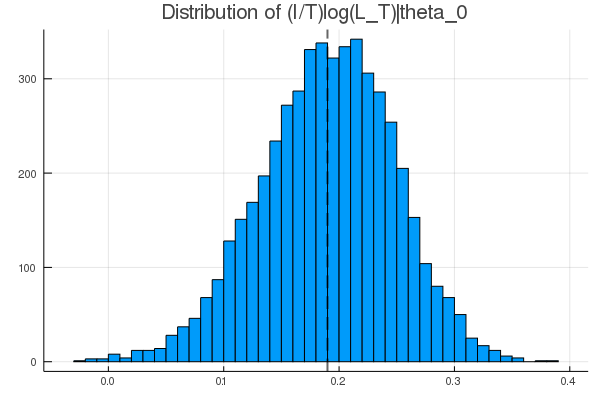

In [6]:
function simulate_likelihood(amf, Xit, Yit)
    # Obter o tamanho
    I, T = size(Xit)

    # Espaço alocado
    LLit = zeros(I, T-1)

    for i in 1:I
        LLit[i, :] = loglikelihood_path(amf, Xit[i, :], Yit[i, :])
    end

    return LLit
end

# Obter a verossimilhança de cada caminho x^{i}, Y^{i}
LLit = simulate_likelihood(amf, Xit, Yit)

LLT = 1 / T * LLit[:, end]
LLmean_t = mean(LLT)

plot(seriestype = :histogram, LLT, label = "")
plot!(title = "Distribution of (I/T)log(L_T)|theta_0")
vline!([LLmean_t], linestyle = :dash, color = :black, lw = 2, alpha = 0.6, label = "")

Observe que a probabilidade do log quase sempre não é negativa, o que implica que $ L_t $ normalmente é maior que 1.

Lembre-se de que a função de verossimilhança é um *pdf* (função de densidade de probabilidade) e **não** uma medida de probabilidade, para que possa assumir valores maiores que 1.

No caso atual, a variação condicional de $ \Delta y_{t + 1} $, que é igual a $ FF^T = 0,04 $, é tão pequena que o valor máximo do pdf é 2 (veja a figura abaixo).

Isso implica que aproximadamente $ 75 \% $ do tempo (um pouco mais de um desvio sigma), devemos esperar que o **incremento** da probabilidade do log seja não-negativo.

Vamos ver isso em uma simulação.

In [7]:
normdist = Normal(0, F)
mult = 1.175
println("The pdf at +/- $mult sigma takes the value: $(pdf(normdist,mult*F))")
println("Probability of dL being larger than 1 is approx: "*
        "$(cdf(normdist,mult*F)-cdf(normdist,-mult*F))")

# Compare isso à analogia simples:
L_increment = LLit[:,2:end] - LLit[:,1:end-1]
r,c = size(L_increment)
frac_nonegative = sum(L_increment.>=0)/(c*r)
print("Fraction of dlogL being nonnegative in the sample is: $(frac_nonegative)")

The pdf at +/- 1.175 sigma takes the value: 1.0001868966924388
Probability of dL being larger than 1 is approx: 0.7600052842019751
Fraction of dlogL being nonnegative in the sample is: 0.7605432432432433

Vamos plotar também a f.d.p. condicional de $ \Delta y_{t+1} $

The pdf at +/- one sigma takes the value: 1.2098536225957168 


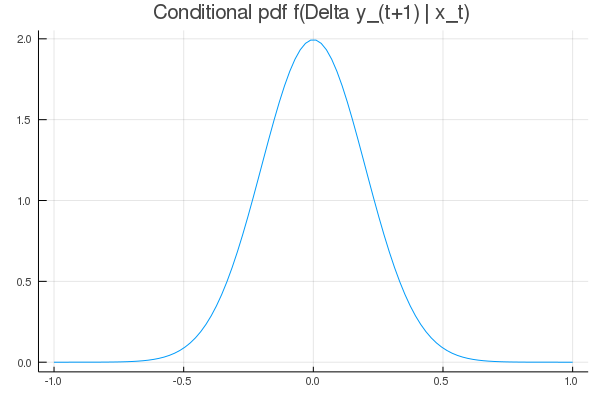

In [8]:
xgrid = range(-1,  1, length = 100)
println("The pdf at +/- one sigma takes the value: $(pdf(normdist, F)) ")
plot(xgrid, pdf.(normdist, xgrid), label = "")
plot!(title = "Conditional pdf f(Delta y_(t+1) | x_t)")

### Um vetor-parâmetro alternativo

Agora considere o vetor de parâmetro alternativo $ \theta_1 = [A, B, D, F] = [0,9, 1,0, 0,55, 0,25] $.

Queremos calcular $ \{\log L_t \mid \theta_1 \}_{t = 1}^T $.

As entradas $ x_t, y_t $ para este programa devem ser exatamente os **mesmos** exemplos de caminhos $ \{x_t^i, y_t^i \}_{t = 0}^T $ que calculamos acima.

Isso ocorre porque queremos gerar dados no modelo de probabilidade $ \theta_o $, mas avaliar a probabilidade no modelo $ \theta_1 $.

Portanto, nossa tarefa é usar nosso programa para simular caminhos de $ I = 5000 $ de $ \{\log L_t^i \mid \theta_1 \}_{t = 1}^T $.

- Para cada caminho, calcule $ \frac {1} {T} \log L_T^i $.
- Então calcule $ \frac {1} {I} \sum_ {i = 1}^I \frac {1} {T} \log L_T^i $.

Queremos comparar esses objetos entre si e com os objetos análogos que computamos acima.

Então queremos interpretar os resultados.

Uma função que construímos pode lidar com essas tarefas.

A única inovação é que devemos criar um modelo alternativo para alimentar.

Vamos chamar criativamente o novo modelo de `amf2`.

Fazemos três gráficos:

- O primeiro prepara o local repetindo um gráfico anterior;
- O segundo contém dois histogramas de valores das probabilidades logarítmicas dos dois modelos no período $ T $, e
- O terceiro compara as probabilidades nos modelos verdadeiro e alternativo.


Aqui está o código:

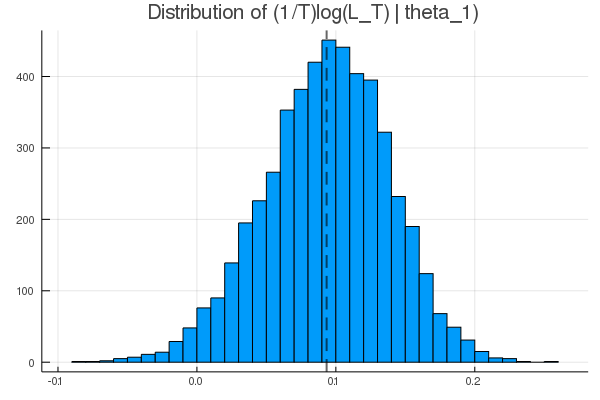

In [9]:
# Criar o segundo modelo alternativo
amf2 = AMF_LSS_VAR(A = 0.9, B = 1.0, D = 0.55, F = 0.25) # parâmetros para θ_1 próximo à θ_0

# Obter a verossimilhança para cada x^{i}, y^{i}
LLit2 = simulate_likelihood(amf2, Xit, Yit)

LLT2 = 1/(T-1) * LLit2[:, end]
LLmean_t2 = mean(LLT2)

plot(seriestype = :histogram, LLT2, label = "")
vline!([LLmean_t2], color = :black, lw = 2, linestyle = :dash, alpha = 0.6, label = "")
plot!(title = "Distribution of (1/T)log(L_T) | theta_1)")

Vamos ver um histograma das log-probabilidades no modelo verdadeiro e alternativo. (mesmos caminhos de amostra)

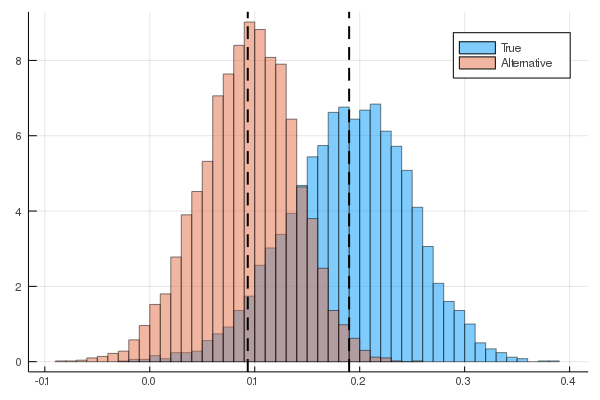

In [10]:
plot(seriestype = :histogram, LLT, bin = 50, alpha = 0.5, label = "True", normed = true)
plot!(seriestype = :histogram, LLT2, bin = 50, alpha = 0.5, label = "Alternative",
      normed = true)
vline!([mean(LLT)], color = :black, lw = 2, linestyle = :dash, label = "")
vline!([mean(LLT2)], color = :black, lw = 2, linestyle = :dash, label = "")

 Agora, traçaremos o histograma da diferença na razão de verossimilhança de log:

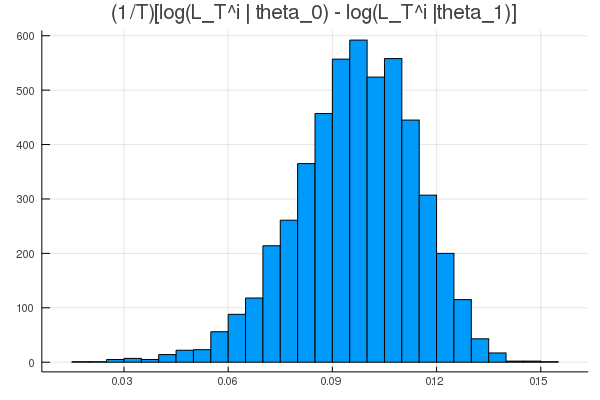

In [11]:
LLT_diff = LLT - LLT2

plot(seriestype = :histogram, LLT_diff, bin = 50, label = "")
plot!(title = "(1/T)[log(L_T^i | theta_0) - log(L_T^i |theta_1)]")

### Interpretação

Esses histogramas de razões de verossimilhança de log ilustram características importantes dos **testes de razão de verossimilhança** como ferramentas para discriminar entre modelos estatísticos.

- A log-probabilidade é, em média, mais alta no modelo verdadeiro - obviamente uma propriedade muito útil.
- No entanto, para uma fração positiva de realizações, o log-probabilidade é maior para o modelo incorreto do que para o verdadeiro.


> - nesses casos, um teste de razão de verossimilhança seleciona erroneamente o modelo errado.



- Essa mecânica está subjacente à teoria estatística das **probabilidades de erro** associadas aos testes de seleção de modelo com base na razão de verossimilhança.


(Em uma aula subsequente, usaremos parte do código preparado nesta aula para ilustrar as probabilidades de erro)

## Benefícios das Flutuações Agregadas Reduzidas

Agora vamos voltar para um novo exemplo de funcionais multiplicativos.

Este exemplo ilustra idéias nas literaturas sobre:

- **risco de longo prazo** na literatura de preços de ativos com base no consumo (por exemplo, [BY04](https://julia.quantecon.org/../zreferences.html#bansalyaron2004), [HHL08](https://julia.quantecon.org/../zreferences.html#hhl2008), [Han07](https://julia.quantecon.org/../zreferences.html#hansen2007))
- **benefícios de eliminar flutuações agregadas** em modelos de macro de agentes representativos (por exemplo, [Tal00](https://julia.quantecon.org/../zreferences.html#tall2000), [Luc03]( https://julia.quantecon.org/../zreferences.html#lucas2003))


Seja $ c_t $ o consumo na data $ t \geq 0 $.

Suponha que $ \{\log c_t \}_{t = 0}^\infty $ seja um funcional aditivo descrito por:

$$
\log c_{t+1} - \log c_t = \nu + D \cdot x_t + F \cdot z_{t+1}
$$

onde

$$
x_{t+1} = A x_t + B z_{t+1}
$$

Aqui $ \{z_{t+1}\}_{t=0}^\infty $ é uma sequência iid de vetores aleatórios $ {\cal N} (0, I) $.

Uma família representativa classifica os processos de consumo $ \{c_t \}_{t = 0}^\infty $ com uma função utilidade $ \{V_t \}_{t = 0}^\infty $ que satisfaz:


<a id='equation-old1mf'></a>
$$
\log V_t - \log c_t = U \cdot x_t + {\sf u} \tag{1}
$$

onde

$$
U = \exp(-\delta) \left[ I - \exp(-\delta) A' \right]^{-1} D
$$

e

$$
{\sf u}
  = {\frac {\exp( -\delta)}{ 1 - \exp(-\delta)}} {\nu} + \frac{(1 - \gamma)}{2} {\frac {\exp(-\delta)}{1 - \exp(-\delta)}}
\biggl| D' \left[ I - \exp(-\delta) A \right]^{-1}B + F \biggl|^2,
$$

Aqui $ \gamma \geq 1 $ é um coeficiente de aversão ao risco e $ \delta> 0 $ é uma taxa de preferência de tempo.

### Consumo como processo multiplicativo

Começamos mostrando que o consumo é um **funcional multiplicativo** com representação:


<a id='equation-old2mf'></a>
$$
\frac{c_t}{c_0}
= \exp(\tilde{\nu}t )
\left( \frac{\tilde{M}_t}{\tilde{M}_0} \right)
\left( \frac{\tilde{e}(x_0)}{\tilde{e}(x_t)} \right) \tag{2}
$$

onde $ \left( \frac{\tilde{M}_t}{\tilde{M}_0} \right) $ é um processo de razão de verossimilhança e $ \tilde M_0 = 1 $.

Neste ponto, como exercício, solicitamos ao leitor que verifique as seguintes fórmulas para $ \tilde {\nu} $ e $ \tilde {e} (x_t) $ como funções de $ A, B, D, F $ :

$$
\tilde \nu =  \nu + \frac{H \cdot H}{2}
$$

e

$$
\tilde e(x) = \exp[g(x)] = \exp \bigl[ D' (I - A)^{-1} x \bigr]
$$

### Simulando novamente um processo de razão de verossimilhança

Em seguida, queremos que um programa simule o processo de taxa de verossimilhança $ \{\tilde {M}_t \}_{t = 0}^\infty $.

Em particular, queremos simular 5000 caminhos de amostra de comprimento $ T = 1000 $ para o caso em que $ x $ é escalar e $ [A, B, D, F] = [0,8, 0,001, 1,0, 0,01] $ e $ \nu = 0,005 $.

Depois de fazer isso, queremos exibir um histograma de $ \tilde {M}_T^i $ para
$ T = 1000 $.

Aqui está o código que realiza essas tarefas:

In [12]:
function simulate_martingale_components(amf, T = 1_000, I = 5_000)
    # Obter a decomposição multiplicativa
    @unpack A, B, D, F, ν, lss = amf
    ν, H, g = multiplicative_decomp(A, B, D, F, ν)

    # Espaço alocado
    add_mart_comp = zeros(I, T)

    # Simule e retire o componente aditivo de martingale
    for i in 1:I
        foo, bar = simulate(lss, T)
        # Componente de Martingale é o terceiro
        add_mart_comp[i, :] = bar[3, :]
    end

    mul_mart_comp = exp.(add_mart_comp' .- (0:T-1) * H^2 / 2)'

    return add_mart_comp, mul_mart_comp
end

# Construir o modelo
amf_2 = AMF_LSS_VAR(A = 0.8, B = 0.001, D = 1.0, F = 0.01, ν = 0.005)

amc, mmc = simulate_martingale_components(amf_2, 1_000, 5_000)

amcT = amc[:, end]
mmcT = mmc[:, end]

println("The (min, mean, max) of additive Martingale component in period T is")
println("\t ($(minimum(amcT)), $(mean(amcT)), $(maximum(amcT)))")

println("The (min, mean, max) of multiplicative Martingale component in period T is")
println("\t ($(minimum(mmcT)), $(mean(mmcT)), $(maximum(mmcT)))")

The (min, mean, max) of additive Martingale component in period T is
	 (-2.012516735067286, -0.004689512192977545, 1.7646420007188783)
The (min, mean, max) of multiplicative Martingale component in period T is
	 (0.11944440630456224, 0.9937743147304434, 5.2187322098431)


#### Comentários

- O mínimo, a média e o máximo anteriores da seção transversal da data
   de realizações em $ T $ do componente de martingale multiplicativo de
   $ c_t $ indicam que a média da amostra está próxima de sua população
   média de 1.
  
   - Esse resultado prevalece para todos os valores do horizonte $ T $.
  
- A distribuição da seção transversal do martingale multiplicativo
   componente de $ c $ na data $ T $ se aproxima de bem de uma distribuição log-normal.
   
- O histograma do componente aditivo de martingale da
   $ \log c_t $ na data $ T $ se aproxima bem de uma distribuição normal.


Aqui está um histograma do componente aditivo de Martingale:

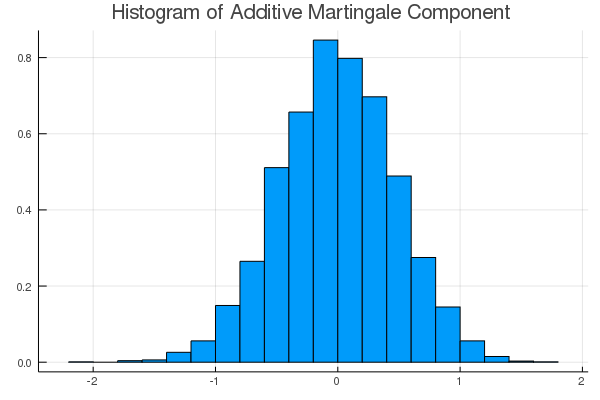

In [13]:
plot(seriestype = :histogram, amcT, bin = 25, normed = true, label = "")
plot!(title = "Histogram of Additive Martingale Component")

Aqui está um histograma do componente de martingale multiplicativo:

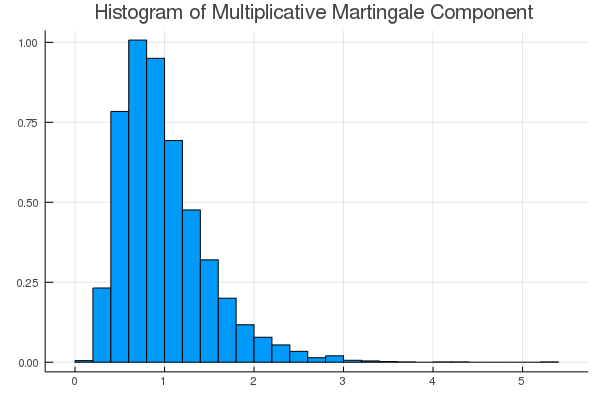

In [14]:
plot(seriestype = :histogram, mmcT, bin = 25, normed = true, label = "")
plot!(title = "Histogram of Multiplicative Martingale Component")

### Representando o processo da razão de verossimilhança

O processo de razão de verossimilhança $ \{\widetilde M_t \} _ {t = 0}^\infty $ pode ser representado como:

$$
\widetilde M_t = \exp \biggl( \sum_{j=1}^t \biggl(H \cdot z_j -\frac{ H \cdot H }{2} \biggr) \biggr),  \quad \widetilde M_0 =1 ,
$$

onde $ H = [F + B'(I-A')^{- 1} D] $.

Segue-se que $ \log {\widetilde M} _t \sim {\mathcal N} (- \frac {t H \cdot H} {2}, t H \cdot H) $ e, consequentemente, $ {\widetilde M} _t $ é log-normal.

Vamos traçar as funções de densidade de probabilidade para $ \log {\widetilde M} _t $ para
$ t = 100, 500, 1000, 10000, 100000 $.

Em seguida, vamos usar os gráficos para investigar como essas densidades evoluem com o tempo.

Plotaremos as densidades de $ \log {\widetilde M} _t $ para diferentes valores de $ t $.

Aqui está um código que lida com essas tarefas:

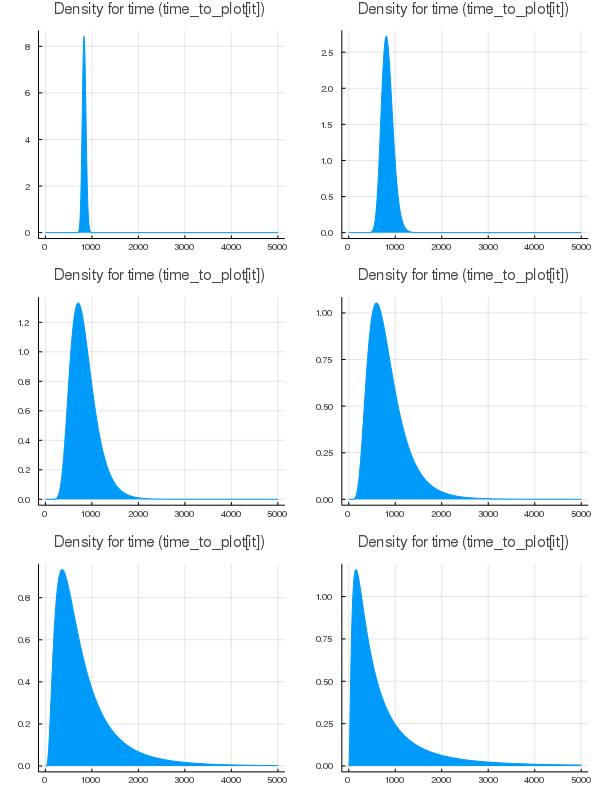

In [15]:
function Mtilde_t_density(amf, t; xmin = 1e-8, xmax = 5.0, npts = 5000)

    # Retire a decomposição multiplicativa
    νtilde, H, g =
        multiplicative_decomp(amf.A, amf.B, amf.D, amf.F, amf.ν)
    H2 = H*H

    # A distribuição
    mdist = LogNormal(-t * H2 / 2, sqrt(t * H2))
    x = range(xmin,  xmax, length = npts)
    p = pdf.(mdist, x)

    return x, p
end

function logMtilde_t_density(amf, t; xmin = -15.0, xmax = 15.0, npts = 5000)

    # Retire a decomposição multiplicativa
    @unpack A, B, D, F, ν = amf
    νtilde, H, g = multiplicative_decomp(A, B, D, F, ν)
    H2 = H * H

    # A distribuição
    lmdist = Normal(-t * H2 / 2, sqrt(t * H2))
    x = range(xmin,  xmax, length = npts)
    p = pdf.(lmdist, x)

    return x, p
end

times_to_plot = [10, 100, 500, 1000, 2500, 5000]
dens_to_plot = [Mtilde_t_density(amf_2, t, xmin=1e-8, xmax=6.0) for t in times_to_plot]
ldens_to_plot = [logMtilde_t_density(amf_2, t, xmin=-10.0, xmax=10.0) for t in times_to_plot]

# título_do_plot = "Densidades de M_t^tilda" é pedido, porém, título_do_plot ainda não é
# suportado nos Plots
plots = plot(layout = (3,2), size = (600,800))

for (it, dens_t) in enumerate(dens_to_plot)
    x, pdf = dens_t
    plot!(plots[it], title = "Density for time (time_to_plot[it])")
    plot!(plots[it], pdf, fillrange = [[0], pdf], label = "")
end
plot(plots)

Essas funções de densidade de probabilidade ilustram uma **propriedade peculiar** dos processos da razão de verossimilhança de log:

- Com relação às verdadeiras probabilidades do modelo, elas têm expectativas matemáticas iguais a $ 1 $ para todos os $ t \geq 0 $.
- Eles quase certamente convergem para zero.  

### Benefícios de bem-estar das flutuações agregadas reduzidas

Suponha que na tradição de uma linha de macroeconomia (por exemplo Tallarini [Tal00](https://julia.quantecon.org/../zreferences.html#tall2000), [Luc03](https://julia.quantecon.org/../zreferences.html#lucas2003)) queremos estimar os benefícios de bem-estar da remoção de flutuações aleatórias em torno do crescimento da tendência.

Calcularemos quanto consumo inicial $ c_0 $ um consumidor representativo que classifica os fluxos de consumo de acordo com [(1)](#equation-old1mf) estaria disposto a sacrificar para aproveitar o fluxo de consumo

$$
\frac{c_t}{c_0} = \exp (\tilde{\nu} t)
$$

em vez do fluxo descrito pela equação [(2)](#equation-old2mf).

Queremos calcular a redução percentual implícita em $ c_0 $ que o consumidor representativo aceitaria.

Para isso, escrevemos uma função que calcula os coeficientes $ U $
e $ u $ para os valores originais de $ A, B, D, F, \nu $, mas
também para o caso em que $ A, B, D, F = [0, 0, 0, 0] $ e
$ \nu = \tilde{\nu} $.

Aqui está nosso código:

In [16]:
function Uu(amf, δ, γ)
    @unpack A, B, D, F, ν = amf
    ν_tilde, H, g = multiplicative_decomp(A, B, D, F, ν)

    resolv = 1 / (1 - exp(-δ) * A)
    vect = F + D * resolv * B

    U_risky = exp(-δ) * resolv * D
    u_risky = exp(-δ) / (1 - exp(-δ)) * (ν + 0.5 * (1 - γ) * (vect^2))

    U_det = 0
    u_det = exp(-δ) / (1 - exp(-δ))  * ν_tilde

    return U_risky, u_risky, U_det, u_det
end

# Definir parâmetros restantes
δ = 0.02
γ = 2.0

# Obter coeficientes
U_r, u_r, U_d, u_d = Uu(amf_2, δ, γ)

(4.54129843114712, 0.24220854072375247, 0, 0.25307727077652764)

Os valores dos dois processos são:

$$
\begin{aligned}
    \log V^r_0 &= \log c^r_0 + U^r x_0 + u^r
     \\
    \log V^d_0 &= \log c^d_0 + U^d x_0 + u^d
\end{aligned}
$$

Procuramos a relação $ \frac {c ^ r_0-c ^ d_0} {c ^ r_0} $ que faz
$ \log V ^ r_0 - \log V ^ d_0 = 0 $

$$
\begin{aligned}
    \underbrace{ \log V^r_0 - \log V^d_0}_{=0} + \log c^d_0 - \log c^r_0
      &= (U^r-U^d) x_0 + u^r - u^d
    \\
 \frac{c^d_0}{ c^r_0}
     &= \exp\left((U^r-U^d) x_0 + u^r - u^d\right)
\end{aligned}
$$

Portanto, a redução percentual implícita em $ c_0 $ que a
consumidor representativo aceitaria é dado por:

$$
\frac{c^r_0-c^d_0}{c^r_0} = 1 - \exp\left((U^r-U^d) x_0 + u^r - u^d\right)
$$

Vamos computar isso:

In [17]:
x0 = 0.0  # condições iniciais
logVC_r = U_r * x0 + u_r
logVC_d = U_d * x0 + u_d

perc_reduct = 100 * (1 - exp(logVC_r - logVC_d))
perc_reduct

1.0809878812017448

Concluímos que o consumidor estaria disposto a reduzir em percentual o consumo inicial em torno de 1,081.